In [27]:
import torch
import numpy as np
import copy
import matplotlib.pyplot as plt
import os
import pickle

from copy import deepcopy

from torch.utils.data import Dataset
import torchvision.transforms as transforms

from tqdm import tqdm

from utilities import *

from torch_tiny_imagenet.NaiveResNet import *
from torch_tiny_imagenet.utils import show_images_horizontally

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [86]:
class BilinearFenchelInfoNCEOne(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         u_func: Optional[nn.Module] = None,
         K: Optional[int] = None,
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearFenchelInfoNCEOne,self).__init__()
        self.critic = critic
        self.u_func = u_func
        self.K = K
    def forward(self, x, y, y0=None,K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        if K is None:
            K = self.K 
#         g = self.critic(x, y)
#         g0 = self.critic(x, y0)
#         u  = self.u_func(x, y)
#         output = u + torch.exp(-u+g0-g) - 1
        output  = self.PMI(x,y,y0,K)
        output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K      
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''

        if self.u_func is not None:
            # two func mode
            u  = self.u_func(x, y)
            if K is not None:
            
                for k in range(K-1):

                    if k==0:
                        y0 = y0
                        g0 = self.critic(x, y0)
                    else:
                        y0 = y[torch.randperm(y.size()[0])]
                        g0 = torch.cat((g0,self.critic(x, y0)),1)

                g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
            else:               
                
                g = self.critic(x, y)
                g0 = self.critic(x, y0)
               
                output = u + torch.exp(-u+g0-g) - 1
        else:
            # one func mode
            gu = self.critic(x,y,None)
            if isinstance(gu, tuple):
                hx,hy,u = gu
                similarity_matrix = hx @ hy.t()
                pos_mask = torch.eye(hx.size(0),dtype=torch.bool)
                g = similarity_matrix[pos_mask].view(hx.size(0),-1)
                g0 = similarity_matrix[~pos_mask].view(hx.size(0),-1)
                g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                output = u + torch.exp(-u+g0_logsumexp-g)/(hx.size(0)-1) - 1

            else:      
                g, u = torch.chunk(self.critic(x,y),2,dim=1)
                if K is not None:

                    for k in range(K-1):

                        if k==0:
                            y0 = y0
                            g0,_ = torch.chunk(self.critic(x,y0),2,dim=1)
                        else:
                            y0 = y[torch.randperm(y.size()[0])]
                            g00,_ = torch.chunk(self.critic(x,y0),2,dim=1)
                            g0 = torch.cat((g0,g00),1)

                    g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                    output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
                else:    

                    g0, _ = torch.chunk(self.critic(x,y0),2,dim=1)
                    output = u + torch.exp(-u+g0-g) - 1
        return output
    
    
class BilinearCriticFenchelInfoNCEOne(nn.Module):
    
    '''
    encoder_x : dx -> feature_dim
    encoder_y : dy -> feature_dim
    u_func : 2*feature_dim -> 1
    '''
    
    def __init__(self,
                 encoder_x: nn.Module,
                 encoder_y: nn.Module,
                 u_func: nn.Module,
                 tau: Optional[float] = 1.):
        
        super(BilinearCriticFenchelInfoNCEOne,self).__init__()
        self.encoder_x = encoder_x
        self.encoder_y = encoder_y
        self.u_func = u_func
        self.log_tau = torch.nn.Parameter(torch.Tensor([np.log(tau)]))
        
    
    def forward(self, x, y, tau=None):
        if tau is None:
            tau = torch.exp(self.log_tau)
        tau = torch.sqrt(tau)
        hx = self.norm(self.encoder_x(x))
        hy = self.norm(self.encoder_y(y))
        u = self.u_func(hx,hy)
        
        return hx/tau, hy/tau, u  
    
    def norm(self,z):
        return torch.nn.functional.normalize(z,dim=1)
        #return z/torch.sqrt(torch.square(z).sum(1).view(-1,1))
        #return z

In [30]:
class ResNetEncoder(nn.Module):
    
    def __init__(self, feature_dim=256, num_blocks=2, normalize=True):
        
        super(ResNetEncoder, self).__init__()
        
        self.resnet = NaiveResNet(num_classes=feature_dim, num_blocks=num_blocks)
        self.normalize = normalize
        
    def forward(self, x):
        
        z = self.resnet(x)
        if self.normalize:
            z = self.norm(z)
        return z
    
    def norm(self,z):
        
        return torch.nn.functional.normalize(z,dim=1)

In [31]:
class BilinearFDVNCE(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearFDVNCE,self).__init__()
        self.critic = critic
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, x, y, y0=None, K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
#         if K is None:
#             K = self.K 
#         g = self.critic(x, y)
#         g0 = self.critic(x, y0)
#         u  = self.u_func(x, y)
#         output = u + torch.exp(-u+g0-g) - 1
        output  = self.PMI(x,y)
#         output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K   
    
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        gxy = self.critic(x,y)
        if isinstance(gxy, tuple):
            hx,hy = gxy
            similarity_matrix = hx @ hy.t()
            
            pos_mask = torch.eye(hx.size(0),dtype=torch.bool)
            g = similarity_matrix[pos_mask].view(hx.size(0),-1)
            g0 = similarity_matrix[~pos_mask].view(hx.size(0),-1)
            
            logits = g0 - g
            
            slogits = torch.logsumexp(logits,1).view(-1,1)
            
            labels = torch.tensor(range(hx.size(0)),dtype=torch.int64).to(device)
            dummy_ce = self.criterion(similarity_matrix,labels) - torch.log(torch.Tensor([hx.size(0)]).to(device))
            dummy_ce = dummy_ce.view(-1,1)
            
            output = dummy_ce.detach()+torch.exp(slogits-slogits.detach())-1
            
        
#             g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
            
#             output = u + torch.exp(-u+g0_logsumexp-g)/(hx.size(0)-1) - 1
                


        else:      
            output = None
#                 g = gxy
#                 if K is not None:

#                     for k in range(K-1):

#                         if k==0:
#                             y0 = y0
#                             g0,_ = torch.chunk(self.critic(x,y0),2,dim=1)
#                         else:
#                             y0 = y[torch.randperm(y.size()[0])]
#                             g00,_ = torch.chunk(self.critic(x,y0),2,dim=1)
#                             g0 = torch.cat((g0,g00),1)

#                     g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
#                     output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
#                 else:    

#                     g0, _ = torch.chunk(self.critic(x,y0),2,dim=1)
#                     output = u + torch.exp(-u+g0-g) - 1
        return output

In [32]:
class BilinearCritic(nn.Module):
    
    '''
    encoder_x : dx -> feature_dim
    encoder_y : dy -> feature_dim
    u_func : 2*feature_dim -> 1
    
    version-1: Jun 3, 2021
      * Made encoder_y optional, for SSL settings multiple-views share the same encoder
    '''
    
    def __init__(self,
                 encoder_x: nn.Module,
                 encoder_y: Optional[nn.Module] = None,
                 u_func: Optional[nn.Module] = None,
                 tau: Optional[float] = 1.):
        
        super(BilinearCritic,self).__init__()
        self.encoder_x = encoder_x
        self.encoder_y = encoder_y
        self.u_func = u_func
        self.log_tau = torch.nn.Parameter(torch.Tensor([np.log(tau)]))
        
    
    def forward(self, x, y, tau=None):
        if tau is None:
            tau = torch.exp(self.log_tau)
        tau = torch.sqrt(tau)
        
        encoder_x = self.encoder_x
        encoder_y = self.encoder_y
        if encoder_y is None:
            encoder_y = encoder_x
            
        hx = self.norm(encoder_x(x))
        hy = self.norm(encoder_y(y))
        if self.u_func is not None:
            u = self.u_func(hx,hy)
            return hx/tau, hy/tau, u  
        
        return hx/tau, hy/tau
    
    def norm(self,z):
        return torch.nn.functional.normalize(z,dim=1)

In [34]:
class BilinearNWJNCE(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearNWJNCE, self).__init__()
        self.critic = critic
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, x, y, y0=None, K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''

        output  = self.PMI(x,y)
#         output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K   
    
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        gxy = self.critic(x,y)
        if isinstance(gxy, tuple):
            hx,hy = gxy
            similarity_matrix = hx @ hy.t()
            
            pos_mask = torch.eye(hx.size(0),dtype=torch.bool)
            g = similarity_matrix[pos_mask].view(hx.size(0),-1)
            g0 = similarity_matrix[~pos_mask].view(hx.size(0),-1)
            
            output = torch.exp(torch.logsumexp(g0,1).view(-1,1)-1.)/torch.Tensor([hx.size(0)]).to(device)-g.view(-1,1)


        else:      
            output = None
                 
        return output

In [35]:
class BilinearInfoNCE(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearInfoNCE,self).__init__()
        self.critic = critic
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, x, y, y0=None, K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
#         if K is None:
#             K = self.K 
#         g = self.critic(x, y)
#         g0 = self.critic(x, y0)
#         u  = self.u_func(x, y)
#         output = u + torch.exp(-u+g0-g) - 1
        output  = self.PMI(x,y)
        output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K   
    
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        gxy = self.critic(x,y)
        if isinstance(gxy, tuple):
            hx,hy = gxy
            similarity_matrix = hx @ hy.t()
            labels = torch.tensor(range(hx.size(0)),dtype=torch.int64).to(device)
            output = self.criterion(similarity_matrix,labels) - torch.log(torch.Tensor([hx.size(0)]).to(device))

        else:      
            output = None
#                 g = gxy
#                 if K is not None:

#                     for k in range(K-1):

#                         if k==0:
#                             y0 = y0
#                             g0,_ = torch.chunk(self.critic(x,y0),2,dim=1)
#                         else:
#                             y0 = y[torch.randperm(y.size()[0])]
#                             g00,_ = torch.chunk(self.critic(x,y0),2,dim=1)
#                             g0 = torch.cat((g0,g00),1)

#                     g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
#                     output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
#                 else:    

#                     g0, _ = torch.chunk(self.critic(x,y0),2,dim=1)
#                     output = u + torch.exp(-u+g0-g) - 1
        return output

In [36]:
class BilinearTUBANCE(nn.Module):
    def __init__(self,
         critic: nn.Module, 
         u_func: Optional[nn.Module] = None,
         K: Optional[int] = None,
         args: Optional[Dict] = None,
         cuda: Optional[int] = None) -> None:
        
        super(BilinearTUBANCE,self).__init__()
        self.critic = critic
        self.u_func = u_func
        self.K = K
    def forward(self, x, y, y0,K=None):
        
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''
        if K is None:
            K = self.K 
#         g = self.critic(x, y)
#         g0 = self.critic(x, y0)
#         u  = self.u_func(x, y)
#         output = u + torch.exp(-u+g0-g) - 1
        output  = self.PMI(x,y,y0,K)
        output = torch.clamp(output,-5,15)
        return output.mean()
    
    def MI(self, x, y, K=10):
        mi = 0
        for k in range(K):
            y0 = y[torch.randperm(y.size()[0])]
            mi += self.forward(x,y,y0)
            
        return -mi/K      
    def PMI(self, x, y, y0=None, K=None):
        '''
        x:    n x p
        y:    n x d true
        y0:   n x d fake 
        '''

        if self.u_func is not None:
            # two func mode
            u  = self.u_func(x)
            if K is not None:
            
                for k in range(K-1):

                    if k==0:
                        y0 = y0
                        g0 = self.critic(x, y0)
                    else:
                        y0 = y[torch.randperm(y.size()[0])]
                        g0 = torch.cat((g0,self.critic(x, y0)),1)

                g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
            else:               
                
                g = self.critic(x, y)
                g0 = self.critic(x, y0)
               
                output = u + torch.exp(-u+g0-g) - 1
        else:
            # one func mode
            gu = self.critic(x,y)
            if isinstance(gu, tuple):
                hx,hy,u = gu
                similarity_matrix = hx @ hy.t()
                pos_mask = torch.eye(hx.size(0),dtype=torch.bool)
                g = similarity_matrix[pos_mask].view(hx.size(0),-1)
                g0 = similarity_matrix[~pos_mask].view(hx.size(0),-1)
                g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                output = u + torch.exp(-u+g0_logsumexp-g)/(hx.size(0)-1) - 1

            else:      
                g, u = torch.chunk(self.critic(x,y),2,dim=1)
                if K is not None:

                    for k in range(K-1):

                        if k==0:
                            y0 = y0
                            g0,_ = torch.chunk(self.critic(x,y0),2,dim=1)
                        else:
                            y0 = y[torch.randperm(y.size()[0])]
                            g00,_ = torch.chunk(self.critic(x,y0),2,dim=1)
                            g0 = torch.cat((g0,g00),1)

                    g0_logsumexp = torch.logsumexp(g0,1).view(-1,1)
                    output = u + torch.exp(-u+g0_logsumexp-g)/(K-1) - 1
                else:    

                    g0, _ = torch.chunk(self.critic(x,y0),2,dim=1)
                    output = u + torch.exp(-u+g0-g) - 1
        return output
    
class TUBABilinearCritic(nn.Module):
    
    '''
    encoder_x : dx -> feature_dim
    encoder_y : dy -> feature_dim
    u_func : 2*feature_dim -> 1
    '''
    
    def __init__(self,
                 encoder_x: nn.Module,
                 encoder_y: nn.Module,
                 u_func: nn.Module,
                 tau: Optional[float] = 1.):
        
        super(TUBABilinearCritic,self).__init__()
        self.encoder_x = encoder_x
        self.encoder_y = encoder_y
        self.u_func = u_func
        self.log_tau = torch.nn.Parameter(torch.log(torch.Tensor([tau])))
        
    
    def forward(self, x, y, tau=None):
        if tau is None:
            tau = torch.exp(self.log_tau)
        tau = torch.sqrt(tau)
        hx = self.norm(self.encoder_x(x))
        hy = self.norm(self.encoder_y(y))
        u = self.u_func(hx)
        
        return hx/tau, hy/tau, u  
    
    def norm(self,z):
        return torch.nn.functional.normalize(z,dim=1)

In [91]:
lam = 1

args = {}
# args['lr'] = 1e-4
args['lr'] = 5e-4
args['latent_dim'] = 100
args['num_epochs'] = 50
# args["input_dim"] = 2*p
args['batch_size']=50

# feature_dim = 512
feature_dim = 4096
# feature_dim = 128

encoder = ResNetEncoder(feature_dim=feature_dim)
# critic = BilinearCritic(encoder)
u_func = Wrapper(MLP(2*feature_dim,hidden_dim=[128]))
critic = BilinearCriticFenchelInfoNCEOne(encoder,encoder,u_func)
# mi_model = BilinearFDVNCE(critic)
mi_model = BilinearFenchelInfoNCEOne(critic)

mi_model = mi_model.to(device)

### Load ImageNet

In [40]:
class ImgDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.paths = x
        self.targets = y
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.paths[index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        target = self.targets[index]
        return img, target

    def __len__(self):
        return len(self.targets)
    
def load_data(data_path='.', device=device):
#     device = 'cuda'
    train_file_path = os.path.join(data_path,'tiny_imagenet','train_tiny_data.pkl')
    test_file_path = os.path.join(data_path,'tiny_imagenet','test_tiny_data.pkl')
    with open(train_file_path, 'rb') as f:
        X_train = pickle.load(f)
        y_train = pickle.load(f).float()
    with open(test_file_path, 'rb') as f:
        X_test = pickle.load(f)
        y_test = pickle.load(f).float()
    return X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

In [41]:
class NewContrastiveDataSet(Dataset):
    def __init__(self, X, Y, name, transforms, n_view = 2, batch_size = 128):
        self.X = X
        self.Y = Y
        self.n_view = n_view
        self.name = name
        self.X1 = None
        self.X2 = None
        self.idx = None
        self.Y1 = None
        self.batch_size = batch_size
        self.transforms = transforms
        self.refresh()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x1 = self.X1[idx]
        x2 = self.X2[idx]
        y1 = self.Y1[idx]
        
        return [x1,x2],y1

    def refresh(self):
        size = 64
        s = .5
        gaussian = False
        
        # transforms_batch = get_simclr_pipeline_newtransform(size, device, s, gaussian)
        transforms_batch = self.transforms
        transforms_individual = []

        idx = np.random.permutation(len(self.X))
        
        self.X1 = deepcopy(self.X)
        self.X2 = deepcopy(self.X)
        self.Y1 = deepcopy(self.Y)
        
        n = len(self.X)
        batch_size = self.batch_size

        for k,transform in enumerate(transforms_individual):
            idx = np.random.permutation(len(self.X))
            self.X1 = self.X1[idx]
            self.X2 = self.X2[idx]
            self.Y1 = self.Y1[idx]
            for i in range(n):
                self.X1[i] = transform(self.X1[i])
                self.X2[i] = transform(self.X2[i])
            
        for k,transform in enumerate(transforms_batch):
            idx = np.random.permutation(len(self.X))
            self.X1 = self.X1[idx]
            self.X2 = self.X2[idx]
            self.Y1 = self.Y1[idx]
            
            for j in range(int(np.ceil(float(n)/batch_size))):
                st = j*batch_size
                ed = min((j+1)*batch_size,n)
                
                x = self.X1[st:ed]
                x = transform(x)
                self.X1[st:ed] = x
                x = self.X2[st:ed]
                x = transform(x)
                self.X2[st:ed] = x
                
        return 

In [42]:
# data_path = os.path.join(os.environ['HOME'],'projects-rick','SimCLR','SimCLR-fast','datasets')

In [43]:
# X_train, y_train, X_test, y_test = load_data(data_path, device=device)

In [44]:
# augmentations = [
#     transforms.RandomApply([transforms.RandomHorizontalFlip()],p=0.5),
#     transforms.RandomApply([transforms.RandomRotation(30)],p=0.9),
#     transforms.RandomApply([transforms.RandomResizedCrop(64,scale=(0.5,1.))],p=0.8),
#     ]

In [45]:
from torchvision import datasets

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

mnist_path = 'data'

# choose the training and test datasets
train_data = datasets.MNIST(root=mnist_path, train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root=mnist_path, train=False,
                                  download=True, transform=transform)

X_train = train_data.data.float()/255.
y_train = train_data.targets
X_test = test_data.data.float()/255.
y_test = test_data.targets

X_train = transforms.Resize(64)(X_train).unsqueeze(1)
X_test = transforms.Resize(64)(X_test).unsqueeze(1)

X_train = X_train[:40000]
y_train = y_train[:40000]

X_test = X_test[:10000]
y_test = y_test[:10000]

X_train = torch.cat([X_train,X_train,X_train],dim=1)
X_test = torch.cat([X_test,X_test,X_test],dim=1)

augmentations = [
#     transforms.RandomApply([transforms.RandomHorizontalFlip()],p=0.5),
    transforms.RandomApply([transforms.RandomRotation(30)],p=0.9),
    transforms.RandomApply([transforms.RandomResizedCrop(64,scale=(0.5,1.))],p=0.8),
    ]

In [46]:
# from torchvision import datasets

# # convert data to torch.FloatTensor
# transform = transforms.ToTensor()

# mnist_path = '../semi-supervised/data'

# # choose the training and test datasets
# train_data = datasets.MNIST(root=mnist_path, train=True,
#                                    download=True, transform=transform)
# test_data = datasets.MNIST(root=mnist_path, train=False,
#                                   download=True, transform=transform)

# augmentations = [
# #     transforms.RandomApply([transforms.RandomHorizontalFlip()],p=0.5),
#     transforms.RandomApply([transforms.RandomRotation(30)],p=0.9),
#     transforms.RandomApply([transforms.RandomResizedCrop(64,scale=(0.5,1.))],p=0.8),
#     ]

In [47]:
# # dir(train_data)
# # train_data.data
# # train_data.targets
# X_train = train_data.data.float()/255.
# y_train = train_data.targets
# X_test = test_data.data.float()/255.
# y_test = test_data.targets

# X_train = transforms.Resize(64)(X_train).unsqueeze(1)
# X_test = transforms.Resize(64)(X_test).unsqueeze(1)

# X_train = torch.cat([X_train,X_train,X_train],dim=1)
# X_test = torch.cat([X_test,X_test,X_test],dim=1)

In [48]:
# augmentations = [
# #     transforms.RandomApply([transforms.RandomHorizontalFlip()],p=0.5),
#     transforms.RandomApply([transforms.RandomRotation(30)],p=0.9),
#     transforms.RandomApply([transforms.RandomResizedCrop(64,scale=(0.5,1.))],p=0.8),
#     ]

In [49]:
train_dataset = NewContrastiveDataSet(X_train,y_train,'train',transforms=augmentations)

In [50]:
args['batch_size'] = 512

In [51]:
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], drop_last=True)

### Check augmentation

In [52]:
train_iter = iter(train_loader)
(x1,x2),y = next(train_iter)

In [53]:
# x1.shape
# x1 = x1.unsqueeze(1)
# x2 = x2.unsqueeze(1)

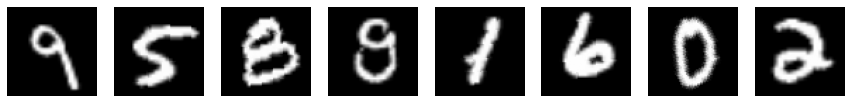

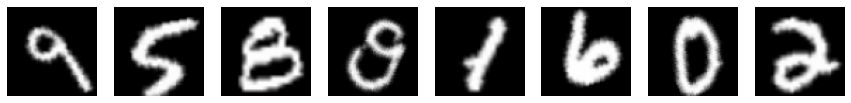

In [54]:
show_images_horizontally(x1[:8].cpu(), un_normalize=False)
show_images_horizontally(x2[:8].cpu(), un_normalize=False)

In [96]:
optimizer = torch.optim.Adam(mi_model.parameters(),lr=args['lr'])
# optimizer = torch.optim.SGD(mi_model.parameters(),lr=args['lr'])

In [97]:
mdl_name = 'flo'
save_dir = 'saved_models'

In [98]:
args['ckpt_interval'] = 5
args['num_epochs'] = 50

In [99]:
mi_model.train() # prep model for training
flo_tinyimg = []

epoch_id = 0
save_path = os.path.join(save_dir,mdl_name)
if os.path.isdir(save_path) is False:
    os.mkdir(save_path)
mdl_file = os.path.join(save_path,'ep_'+str(epoch_id).zfill(4)+'.ckpt')
torch.save(mi_model, mdl_file)

for epoch_counter in range(0, args['num_epochs']):
    
    epoch_id = epoch_counter+1
    
    # monitor training loss
    train_loss = 0.0
    train_mi = 0.0
    ###################
    # train the model #
    ###################
#     model.train()
    mi_model.train()
    for i, (images, _) in enumerate(tqdm(train_loader)):
        z_left, z_right = images
        z_left = z_left.to(device)
        z_right = z_right.to(device)
        # load the (un)labeled data
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        mi_loss = mi_model(z_left,z_right)
#         print(mi_loss)
        # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
        # calculate the loss
        total_loss = mi_loss
        # backward pass: compute gradient of the loss with respect to model parameters
        total_loss.backward()
        optimizer.step()
        # perform a single optimization step (parameter update)
        
        # update running training loss
        # train_loss += loss.item()*data.size(0)
        train_mi += -mi_loss.item()*z_left.size(0)
        
    train_loader.dataset.refresh()
    
    train_mi = train_mi/len(y_train)
    print('Epoch: {}\t MI: {:4f}'.format(epoch_id, train_mi))
    flo_tinyimg.append(train_mi)
    np.save(os.path.join(save_path,'train_mi.npy'), flo_tinyimg)

    if epoch_id%args['ckpt_interval']==0:
        mdl_file = os.path.join(save_path,'ep_'+str(epoch_id).zfill(4)+'.ckpt')
        torch.save(mi_model, mdl_file)


  1%|▏         | 1/78 [00:00<00:10,  7.58it/s]

Epoch: 1	 MI: 0.753715


  1%|▏         | 1/78 [00:00<00:10,  7.48it/s]

Epoch: 2	 MI: 0.910104


  1%|▏         | 1/78 [00:00<00:10,  7.01it/s]

Epoch: 3	 MI: 0.977930


  1%|▏         | 1/78 [00:00<00:10,  7.49it/s]

Epoch: 4	 MI: 1.031264


  1%|▏         | 1/78 [00:00<00:10,  7.57it/s]

Epoch: 5	 MI: 1.095041


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

Epoch: 6	 MI: 1.161559


  1%|▏         | 1/78 [00:00<00:10,  7.52it/s]

Epoch: 7	 MI: 1.225004


  1%|▏         | 1/78 [00:00<00:10,  7.42it/s]

Epoch: 8	 MI: 1.284707


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

Epoch: 9	 MI: 1.352678


  1%|▏         | 1/78 [00:00<00:10,  7.46it/s]

Epoch: 10	 MI: 1.418622


  1%|▏         | 1/78 [00:00<00:10,  7.47it/s]

Epoch: 11	 MI: 1.492257


  1%|▏         | 1/78 [00:00<00:11,  6.88it/s]

Epoch: 12	 MI: 1.566135


  1%|▏         | 1/78 [00:00<00:10,  7.53it/s]

Epoch: 13	 MI: 1.643130


  1%|▏         | 1/78 [00:00<00:10,  7.54it/s]

Epoch: 14	 MI: 1.721386


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 15	 MI: 1.814528


  1%|▏         | 1/78 [00:00<00:10,  7.53it/s]

Epoch: 16	 MI: 1.896735


  1%|▏         | 1/78 [00:00<00:10,  7.45it/s]

Epoch: 17	 MI: 1.994347


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

Epoch: 18	 MI: 2.096189


  1%|▏         | 1/78 [00:00<00:10,  7.48it/s]

Epoch: 19	 MI: 2.201361


100%|██████████| 78/78 [00:10<00:00,  7.28it/s]


Epoch: 20	 MI: 2.318770


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

Epoch: 21	 MI: 2.440566


  1%|▏         | 1/78 [00:00<00:10,  7.59it/s]

Epoch: 22	 MI: 2.562572


  1%|▏         | 1/78 [00:00<00:10,  7.55it/s]

Epoch: 23	 MI: 2.701714


  1%|▏         | 1/78 [00:00<00:10,  7.47it/s]

Epoch: 24	 MI: 2.840031


  1%|▏         | 1/78 [00:00<00:10,  7.01it/s]

Epoch: 25	 MI: 2.981368


  1%|▏         | 1/78 [00:00<00:10,  7.48it/s]

Epoch: 26	 MI: 3.143685


  1%|▏         | 1/78 [00:00<00:10,  7.60it/s]

Epoch: 27	 MI: 3.310076


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

Epoch: 28	 MI: 3.497225


  1%|▏         | 1/78 [00:00<00:10,  7.52it/s]

Epoch: 29	 MI: 3.667146


100%|██████████| 78/78 [00:10<00:00,  7.27it/s]


Epoch: 30	 MI: 3.855137


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

Epoch: 31	 MI: 4.054105


  1%|▏         | 1/78 [00:00<00:10,  7.48it/s]

Epoch: 32	 MI: 4.258234


  1%|▏         | 1/78 [00:00<00:10,  7.52it/s]

Epoch: 33	 MI: 4.473292


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

Epoch: 34	 MI: 4.694270


100%|██████████| 78/78 [00:10<00:00,  7.29it/s]


Epoch: 35	 MI: 4.823854


  1%|▏         | 1/78 [00:00<00:10,  7.47it/s]

Epoch: 36	 MI: 4.898257


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

Epoch: 37	 MI: 4.927777


  1%|▏         | 1/78 [00:00<00:10,  7.50it/s]

Epoch: 38	 MI: 4.940723


  1%|▏         | 1/78 [00:00<00:10,  7.47it/s]

Epoch: 39	 MI: 4.941489


100%|██████████| 78/78 [00:10<00:00,  7.25it/s]


Epoch: 40	 MI: 4.944382


  1%|▏         | 1/78 [00:00<00:10,  7.44it/s]

Epoch: 41	 MI: 4.952168


  1%|▏         | 1/78 [00:00<00:10,  7.50it/s]

Epoch: 42	 MI: 4.959760


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

Epoch: 43	 MI: 4.965754


  1%|▏         | 1/78 [00:00<00:10,  7.61it/s]

Epoch: 44	 MI: 4.968989


100%|██████████| 78/78 [00:10<00:00,  7.30it/s]


Epoch: 45	 MI: 4.967507


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

Epoch: 46	 MI: 4.957488


  1%|▏         | 1/78 [00:00<00:10,  7.49it/s]

Epoch: 47	 MI: 4.972427


  1%|▏         | 1/78 [00:00<00:10,  7.53it/s]

Epoch: 48	 MI: 4.971064


  1%|▏         | 1/78 [00:00<00:10,  7.49it/s]

Epoch: 49	 MI: 4.966908


100%|██████████| 78/78 [00:10<00:00,  7.27it/s]


Epoch: 50	 MI: 4.970550


In [ ]:
feature_dim